In [ ]:
%%capture
!pip install langchain
!pip install -U langchain-google-genai

In [ ]:
import os
import re
import json
import heapq
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time

from tqdm import tqdm
from google.colab import userdata
from collections import defaultdict
from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/Projects/GNN-Gene-Disease/Data'

## Tables View

In [ ]:
df_diseaseDOID = pd.read_csv(PATH + '/D-DoMiner_miner-diseaseDOID.tsv', sep='	')
df_diseaseDOID['Name'] = df_diseaseDOID['Name'].transform(lambda x: x.title())

In [ ]:
df_diseaseDOID.head()

In [ ]:
df_disease = pd.read_csv(PATH + '/D-MeshMiner_miner-disease.tsv', sep='	')
df_disease['Name'] = df_disease['Name'].transform(lambda x: x.title())
df_disease.head()

In [ ]:
df_disease_class = pd.read_csv(PATH + '/D-DoPathways_diseaseclasses.csv')
df_disease_class['Disease Name'] = df_disease_class['Disease Name'].transform(lambda x: x.title())
df_disease_class.head()

In [ ]:
sdasdfdf_geneHUGO = pd.read_csv(PATH + '/G-SynMiner_miner-geneHUGO.tsv', sep='	')
sdasdfdf_geneHUGO

In [ ]:
df_geneHUGO = pd.read_csv(PATH + '/G-SynMiner_miner-geneHUGO.tsv', sep='	')
df_geneHUGO = df_geneHUGO[['entrez_id', 'hgnc_id', 'name', 'locus_group', 'locus_type', 'location', 'gene_family', 'gene_family_id']]
df_geneHUGO.head()

In [ ]:
df_disease_gene = pd.read_csv(PATH + '/DG-AssocMiner_miner-disease-gene.tsv', sep='	')
df_disease_gene['Disease Name'] = df_disease_gene['Disease Name'].transform(lambda x: x.title())

print(df_disease_gene.info(verbose=True))
print(df_disease_gene.head())

## Disease Feature Table


In [ ]:
df_disease_ = df_disease_gene[['# Disease ID', 'Disease Name']].drop_duplicates()

df_disease_.columns=['Disease ID', 'Disease Name']

# Merge with disease class
df_disease_ = df_disease_.merge(df_disease_class, on='Disease ID', how='left')
df_disease_ = df_disease_.drop(columns=['Disease Name_y'])

df_disease_.columns=['Disease ID', 'Disease Name', 'Disease Class']

df_disease_

In [ ]:
# Merge with miner disease
df_disease_2 = df_disease_.merge(df_disease, left_on='Disease Name', right_on = 'Name', how='left')

df_disease_2

In [ ]:
# Merge with DOID disease
df_disease_3 = df_disease_2.merge(df_diseaseDOID, left_on='Disease Name', right_on = 'Name', how='left')

df_disease_3

In [ ]:
df_disease_3.drop(columns=['Name_x', 'Name_y', '# MESH_ID', 'Synonyms', 'Synonym'],inplace=True)

In [ ]:
nan_sum = df_disease_3.isna().sum()
print(nan_sum)

In [ ]:
df_disease_3

### Adding missing Definitions and merging into one column

In [ ]:
col_doid = '# Disease(DOID)'
col_definition = 'Definition'
col_definitions = 'Definitions'

required_cols = [col_doid, col_definition, col_definitions]
if all(col in df_disease_3.columns for col in required_cols):

    condition1 = df_disease_3[col_definition].isnull()

    condition2 = df_disease_3[col_definitions].isnull()

    condition3 = df_disease_3[col_doid].notna()
    # Alternative for condition3: condition3 = df_disease_3[col_doid].isnull() == False

    combined_condition = condition1 & condition2 & condition3

    # Apply the filter
    filtered_df_specific_3 = df_disease_3[combined_condition]

    # Print the shape of the resulting DataFrame
    print(f"Original DataFrame shape: {df_disease_3.shape}")
    print(f"Filtered DataFrame shape (rows where '{col_definition}' is NaN AND '{col_definitions}' is NaN AND '{col_doid}' is not NaN): {filtered_df_specific_3.shape}")

    # Display the first few rows of the filtered DataFrame (optional)
    if not filtered_df_specific_3.empty:
        print(f"\n Rows matching the criteria ('{col_definition}' NaN, '{col_definitions}' NaN, '{col_doid}' not NaN):")
        # Display columns relevant to the condition for clarity
        print(filtered_df_specific_3[[col_doid, col_definition, col_definitions]])
    else:
        print("\nNo rows found matching the specified criteria.")

else:
    # Find which column is missing
    missing_cols = [col for col in required_cols if col not in df_disease_3.columns]
    print(f"Error: One or more required columns not found in df_disease_3. Missing: {missing_cols}")
    # Specifically check for the potentially misspelled 'definitions'
    if col_definitions not in df_disease_3.columns:
          print(f"Note: The column '{col_definitions}' (plural) was not found. Did you perhaps mean '{col_definition}' (singular)?")


In [ ]:
doid_to_definition_map = {
    'DOID:0050458': 'A myelodysplastic/myeloproliferative neoplasm that is characterized by the uncontrolled growth of monocytes.', # Replace ... with the definition for DOID:0050458
    'DOID:0080016': 'A neural tube defect that is characterized by incomplete closing of the spine and membranes around the spinal cord during early development.', # etc.
    'DOID:5773': 'A mouth disease that is characterized by juxta-epithelial inflammatory reaction and progressive fibrosis of the submucosal tissues.',
    'DOID:11714': 'A diabetes mellitus that manifests during pregnancy.',
    'DOID:0050562': 'An infancy electroclinical syndrome that is characterized by infantile spasms, hypsarrhythmia on electroencephalogram and intellectual disability.'
}

In [ ]:
col_doid = '# Disease(DOID)'
col_definition = 'Definition'

if col_doid in df_disease_3.columns and col_definition in df_disease_3.columns:

    updated_count = 0
    doids_updated = []
    doids_not_found_in_df = []

    print("Attempting to update definitions...")

    for doid, definition in doid_to_definition_map.items():
        if definition and definition != '...': # Check if a definition was actually provided

            mask = (df_disease_3[col_doid] == doid) & (df_disease_3[col_definition].isnull())

            if mask.any():
                df_disease_3.loc[mask, col_definition] = definition
                updated_count += mask.sum()
                doids_updated.append(doid)
            else:
                # Check if the DOID exists at all in the DataFrame
                if not (df_disease_3[col_doid] == doid).any():
                    doids_not_found_in_df.append(doid)

    print(f"\nUpdate complete.")
    print(f"Number of rows updated: {updated_count}")
    if doids_updated:
        print(f"Definitions updated for DOIDs: {sorted(doids_updated)}")
    if doids_not_found_in_df:
          print(f"Warning: DOIDs from your map not found in '{col_doid}' column: {sorted(doids_not_found_in_df)}")
    # Verify by showing a sample of updated rows (optional)
    if doids_updated:
        print("\nSample of rows after potential update (showing relevant DOIDs):")
        print(df_disease_3[df_disease_3[col_doid].isin(doids_updated)][[col_doid, col_definition]].head())

else:
    print(f"Error: One or both columns ('{col_doid}', '{col_definition}') not found in df_disease_3.")

In [ ]:
col_definition = 'Definition'
col_definitions = 'Definitions'

# Iterate through the DataFrame rows
for index, row in df_disease_3.iterrows():
    if pd.isna(row[col_definitions]) and not pd.isna(row[col_definition]):
        df_disease_3.loc[index, col_definitions] = row[col_definition]


In [ ]:
df_disease_3.drop(columns=['Definition'],inplace=True)

In [ ]:
df_disease_3.to_csv('/content/drive/MyDrive/Projects/GNN-Gene-Disease/Data/processed_data/diseaseTableMinerFinal.csv', index= False)

## Genes feature table

In [ ]:
processed_data_old = PATH + '/processed_data/Old'

df_gene_pp = pd.read_csv(processed_data_old + '/genes_table.csv')
df_gene_pp.head()

In [ ]:
# Define column names
source_col = 'hgnc_id'
new_col = 'id'

# --- Step 1: Create the new 'id' column ---
print(f"Creating new column '{new_col}' from '{source_col}' by extracting numbers...")

# Extract numeric part from 'hgnc_id' using regex
df_geneHUGO[new_col] = df_geneHUGO[source_col].str.extract(r'(\d+)', expand=False)

# Convert the new 'id' column to a numeric type, coercing errors to NaN
df_geneHUGO[new_col] = pd.to_numeric(df_geneHUGO[new_col], errors='coerce')

print(f"Column '{new_col}' created and converted to numeric.")

# --- Step 2: Drop the original 'hgnc_id' column ---
col_to_drop = source_col # Same as 'hgnc_id'
print(f"\nAttempting to drop original column: '{col_to_drop}'...")

# Drop the column inplace
df_geneHUGO.drop(columns=[col_to_drop], inplace=True, errors='ignore')

print(df_geneHUGO[[new_col]].head(10)) # Adjust columns shown as needed

print("\nFinal columns in DataFrame:")
print(df_geneHUGO.columns.tolist())

print("\nData types:")
print(df_geneHUGO[[new_col]].dtypes) # Show dtype for the new column

In [ ]:
# Split the 'location' column using df_geneHUGO
df_geneHUGO['Start Chromossome'] = df_geneHUGO['location'].str.extract(r'(\d+)')
df_geneHUGO['Start Chromossome Arm'] = df_geneHUGO['location'].str.extract(r'\d+([pq])')
df_geneHUGO['Start Chromossome Loc'] = df_geneHUGO['location'].str.extract(r'[pq](\d+)')
df_geneHUGO['Start Chromossome SubLoc'] = df_geneHUGO['location'].str.extract(r'\.(\d+)')
df_geneHUGO['End Chromossome Arm'] = df_geneHUGO['location'].str.extract(r'-([pq])')
df_geneHUGO['End Chromossome Loc'] = df_geneHUGO['location'].str.extract(r'-(?:p|q)?(\d+)\.\d+')
df_geneHUGO['End Chromossome SubLoc'] = df_geneHUGO['location'].str.extract(r'-(?:p|q)?\d+\.(\d+)')

df_geneHUGO

In [ ]:
# Getting only genes that appears on the gene-disease edges dataset

hugo_id_col = 'id'
disease_gene_id_col = 'Gene ID'

print(f"Filtering df_geneHUGO based on IDs in df_disease_gene['{disease_gene_id_col}']...")

# 1. Get the set of unique Gene IDs from df_disease_gene
valid_gene_ids = set(df_disease_gene[disease_gene_id_col].unique())

# 2. Create a boolean mask using .isin()
mask = df_geneHUGO[hugo_id_col].isin(valid_gene_ids)

# 3. Apply the mask to filter df_geneHUGO
filtered_df_geneHUGO = df_geneHUGO[mask]

# --- Output and Verification ---
print(f"\nOriginal df_geneHUGO shape: {df_geneHUGO.shape}")
print(f"Number of unique Gene IDs in reference: {len(valid_gene_ids)}")
print(f"Filtered df_geneHUGO shape: {filtered_df_geneHUGO.shape}")

# Display the first few rows of the filtered DataFrame
df_geneHUGO = filtered_df_geneHUGO
df_geneHUGO.head()

In [ ]:
df_geneHUGO.to_csv('/content/drive/MyDrive/Projects/GNN-Gene-Disease/Data/processed_data/genes_table_HUGO_final.csv', index = False)

## Add Disease Features LLM

In [ ]:
processed_data = PATH + '/processed_data'

df_disease_pp = pd.read_csv(processed_data + '/diseaseTableMinerFinal.csv', )
df_disease_pp.head()

In [ ]:
if 'main_system_affected' not in df_disease_pp.columns:
    df_disease_pp['main_system_affected'] = pd.NA # Ensure column exists

In [ ]:
df_disease_pp.to_csv('/content/drive/MyDrive/Projects/GNN-Gene-Disease/Data/processed_data/df_final_processed_without_Gemini.csv', index = False)

In [ ]:
gemini_API_KEY = userdata.get('GOOGLE_API_KEY')

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = gemini_API_KEY

In [ ]:
# Initialize model
llm1 = ChatGoogleGenerativeAI(
    model="gemini-2.5-pro-exp-03-25",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# Initialize model
llm2 = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-04-17",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [ ]:
def build_dynamic_prompt_parts(disease_name, current_definition, current_disease_class):
    prompt_context_parts = [f"Disease Name: {disease_name}"]
    json_fields_to_request = {}
    task_list_for_llm = []

    needs_definition_from_llm = pd.isna(current_definition) or not str(current_definition).strip()
    if needs_definition_from_llm:
        json_fields_to_request['definition'] = "A concise and informative definition of the disease."
        task_list_for_llm.append("- Generate a 'definition'.")
    elif pd.notna(current_definition) and str(current_definition).strip():
        prompt_context_parts.append(f"Existing Definition (for context): {str(current_definition).strip()}")

    needs_class_from_llm = pd.isna(current_disease_class) or not str(current_disease_class).strip()
    if needs_class_from_llm:
        json_fields_to_request['disease_class'] = "The class of this disease (e.g., genetic, infectious, autoimmune, cancer, metabolic, etc.)."
        task_list_for_llm.append("- Determine the 'disease_class'.")
    elif pd.notna(current_disease_class) and str(current_disease_class).strip():
        prompt_context_parts.append(f"Current Known Disease Class (for context): {str(current_disease_class).strip()}")

    json_fields_to_request['main_system_affected'] = "The primary physiological system most directly affected (e.g., cardiovascular, respiratory, nervous, etc.)."
    task_list_for_llm.append("- Identify the 'main_system_affected'.")

    return prompt_context_parts, json_fields_to_request, task_list_for_llm, needs_definition_from_llm, needs_class_from_llm


In [ ]:
SYSTEM_MESSAGE_CONTENT = (
    "You are an expert biomedical data extraction and generation assistant. "
    "Your task is to analyze disease information and return specific details "
    "in a structured JSON format. Respond ONLY with a single, valid JSON object "
    "adhering to the specified keys. Do not include any other text or markdown."
)

In [ ]:
def process_df_batch(llm_client, df_to_process, start_index, end_index):
    """
    Processes a specified slice of the DataFrame using the provided LLM client.

    Args:
        llm_client: The initialized LLM client (e.g., ChatGoogleGenerativeAI instance).
        df_to_process: The pandas DataFrame to process.
        start_index: The starting row index for processing (inclusive).
        end_index: The ending row index for processing (exclusive).

    Returns:
        A tuple containing:
            - df_processed: The DataFrame with updates from this batch.
            - batch_log: A list of log entries for this batch.
    """
    if llm_client is None:
        print("LLM client is None. Skipping batch processing.")
        return df_to_process, []

    batch_log = []
    # Make a copy to avoid SettingWithCopyWarning if df_to_process is a slice itself
    # and to ensure modifications are explicitly handled.
    df_processed = df_to_process.copy()

    REQUEST_DELAY_SECONDS = 6

    print(f"\n--- Processing batch with {llm_client.model if hasattr(llm_client, 'model') else 'Unknown LLM'} from row {start_index} to {end_index-1} (with ~{REQUEST_DELAY_SECONDS}s delay per request) ---")

    # Iterate over the specified slice of the DataFrame
    # .iloc is used for positional slicing
    for i in range(start_index, min(end_index, len(df_processed))):
        original_df_index = df_processed.index[i] # Get the original index label
        row = df_processed.iloc[i]
        disease_name = str(row['Disease Name'])

        (prompt_context_parts, json_fields_to_request, task_list_for_llm,
         needs_definition_from_llm, needs_class_from_llm) = build_dynamic_prompt_parts(
            disease_name, row['Definitions'], row['Disease Class']
        )

        if not json_fields_to_request:
            print(f"Skipping {disease_name} (row index {original_df_index}): No information to request.")
            batch_log.append({"disease": disease_name, "original_index": original_df_index, "status": "skipped_no_request"})
            continue

        json_schema_example = "{{\n{}\n}}".format(",\n".join([f'  "{k}": "..."' for k in json_fields_to_request.keys()]))
        field_descriptions_string = "\n".join([f'- "{k}": {v}' for k, v in json_fields_to_request.items()])

        human_prompt_text = f"""
Analyze: {", ".join(prompt_context_parts)}
Your task is to provide details for the disease above.
Respond with a single JSON object including ONLY these keys:
{json_schema_example}
Key descriptions:
{field_descriptions_string}
Tasks: {" ".join(task_list_for_llm)}
Be factual and concise. Only return the JSON.
"""
        messages = [("system", SYSTEM_MESSAGE_CONTENT), ("human", human_prompt_text)]

        status_prefix = f"Row {original_df_index} ({disease_name:<25})"
        try:
            time.sleep(REQUEST_DELAY_SECONDS)

            response = llm_client.invoke(messages)
            response_content = response.content.strip()

            if not response_content.startswith("{") or not response_content.endswith("}"):
                match = re.search(r'\{[\s\S]*\}', response_content)
                if match: response_content = match.group(0)
                else: raise json.JSONDecodeError("No valid JSON block found.", response_content, 0)

            data = json.loads(response_content)

            updated_fields_count = 0
            if needs_definition_from_llm and data.get("definition"):
                df_processed.loc[original_df_index, 'Definitions'] = str(data["definition"]).strip()
                updated_fields_count +=1
            if needs_class_from_llm and data.get("disease_class"):
                df_processed.loc[original_df_index, 'Disease Class'] = str(data["disease_class"]).strip()
                updated_fields_count +=1
            if data.get("main_system_affected"):
                df_processed.loc[original_df_index, 'main_system_affected'] = str(data["main_system_affected"]).strip()
                updated_fields_count +=1

            print(f"{status_prefix} SUCCESS ({updated_fields_count} fields updated).")
            batch_log.append({"disease": disease_name, "original_index": original_df_index, "status": "success", "data": data, "updated_count": updated_fields_count})

        except Exception as e:
            error_summary = str(e).split('\n')[0]
            print(f"{status_prefix} ERROR: {type(e).__name__} - {error_summary}")
            batch_log.append({"disease": disease_name, "original_index": original_df_index, "status": "error", "error_message": str(e)})
            # Optional: re-raise if you want to stop processing on first error
            # raise

    return df_processed, batch_log

In [ ]:
total_rows = len(df_disease_pp)
mid_point = total_rows - 100

all_logs = []

In [ ]:
# Process the first half with llm1
df_after_batch1, log_batch1 = process_df_batch(llm2, df_disease_pp, 0, mid_point)
all_logs.extend(log_batch1)

print("\n\n--- Overall Processing Complete ---")
print("\nFinal Updated DataFrame sample (first 8 rows):")
relevant_columns = ['Disease Name', 'Definitions', 'Disease Class', 'main_system_affected']
print(df_after_batch1[relevant_columns].head(8)) # Display more rows if your sample df is larger

print("\n--- Combined Log Summary (first 10 entries) ---")
df_all_logs = pd.DataFrame(all_logs)
print(df_all_logs.head(10))

df_after_batch1.to_csv('/content/drive/MyDrive/Projetos/GNN-Gene-Disease/Data/processed_data/df_final_processed.csv', index = False)


--- Processing batch with models/gemini-2.5-flash-preview-04-17 from row 0 to 418 (with ~6s delay per request) ---
Row 0 (Salivary Gland Neoplasms ) SUCCESS (2 fields updated).
Row 1 (Psychoses, Substance-Induced) SUCCESS (2 fields updated).
Row 2 (Zellweger Syndrome       ) SUCCESS (1 fields updated).
Row 3 (Psoriasis                ) SUCCESS (1 fields updated).
Row 4 (Nephrotic Syndrome       ) SUCCESS (1 fields updated).
Row 5 (Common Migraine          ) SUCCESS (2 fields updated).
Row 6 (Mouth Diseases           ) SUCCESS (2 fields updated).
Row 7 (Mitochondrial Complex I Deficiency) SUCCESS (2 fields updated).
Row 8 (Substance-Related Disorders) SUCCESS (1 fields updated).
Row 9 (Anemia, Hemolytic        ) SUCCESS (1 fields updated).
Row 10 (Rheumatoid Arthritis     ) SUCCESS (1 fields updated).
Row 11 (Arthritis, Psoriatic     ) SUCCESS (1 fields updated).
Row 12 (Anemia                   ) SUCCESS (1 fields updated).
Row 13 (Cholangiocarcinoma       ) SUCCESS (1 fields updated)

KeyError: "['DOID'] not in index"

In [ ]:
df_after_batch1 = pd.read_csv('/content/drive/MyDrive/Projects/GNN-Gene-Disease/Data/processed_data/df_final_processed.csv')

# Process the second half with llm2, using the DataFrame updated by the first batch
# Note: df_after_batch1 contains the updates from the first run.
df_final_processed, log_batch2 = process_df_batch(llm2, df_after_batch1, mid_point, total_rows)
all_logs.extend(log_batch2)

print("\n\n--- Overall Processing Complete ---")
print("\nFinal Updated DataFrame sample (first 8 rows):")
relevant_columns = ['Disease Name', 'Definitions', 'Disease Class', 'main_system_affected']
print(df_final_processed[relevant_columns].head(8)) # Display more rows if your sample df is larger

print("\n--- Combined Log Summary (first 10 entries) ---")
df_all_logs = pd.DataFrame(all_logs)
print(df_all_logs.head(10))


--- Processing batch with models/gemini-2.5-flash-preview-04-17 from row 419 to 518 (with ~6s delay per request) ---
Row 419 (Meningioma               ) SUCCESS (1 fields updated).
Row 420 (Cachexia                 ) SUCCESS (2 fields updated).
Row 421 (Respiratory Insufficiency) SUCCESS (2 fields updated).
Row 422 (Respiratory Hypersensitivity) SUCCESS (2 fields updated).
Row 423 (Nasopharyngeal Carcinoma ) SUCCESS (3 fields updated).
Row 424 (Hyperalgesia             ) SUCCESS (2 fields updated).
Row 425 (Leber Congenital Amaurosis) SUCCESS (1 fields updated).
Row 426 (Sudden Cardiac Arrest    ) SUCCESS (3 fields updated).
Row 427 (Intellectual Disability  ) SUCCESS (2 fields updated).
Row 428 (Graves Disease           ) SUCCESS (1 fields updated).
Row 429 (Neurotoxicity Syndromes  ) SUCCESS (1 fields updated).
Row 430 (Cardiomyopathy, Familial Hypertrophic, 1 (Disorder)) SUCCESS (3 fields updated).
Row 431 (Atrial Fibrillation      ) SUCCESS (1 fields updated).
Row 432 (Hepatitis, 

KeyError: "['DOID'] not in index"

In [ ]:
df_final_processed.to_csv('/content/drive/MyDrive/Projects/GNN-Gene-Disease/Data/processed_data/df_final_processed.csv', index = False)

## Graph

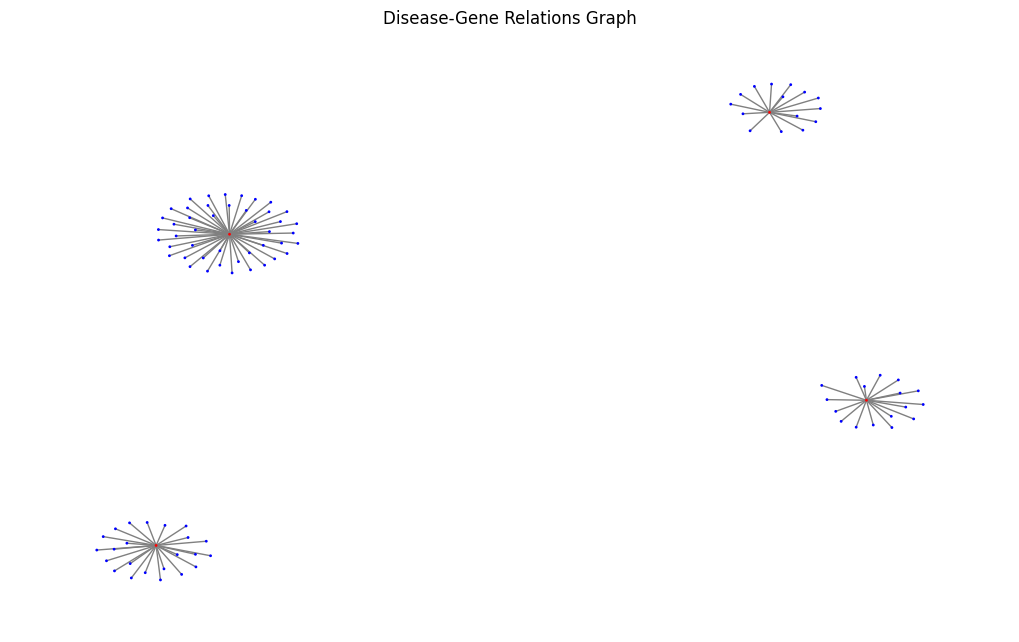

In [ ]:
# Creating a graph from the DataFrame
G = nx.from_pandas_edgelist(df_disease_gene[:300], '# Disease ID', 'Gene ID')

node_colors = []
for node in G.nodes():
    if isinstance(node, int):  # Assuming Gene ID is an integer
        node_colors.append('blue')  # Color for Gene nodes
    else:
        node_colors.append('red')  # Color for Disease nodes

# Plotting the graph
plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=False, edge_color='gray',node_color=node_colors, node_size=1)
plt.title('Disease-Gene Relations Graph')
plt.show()

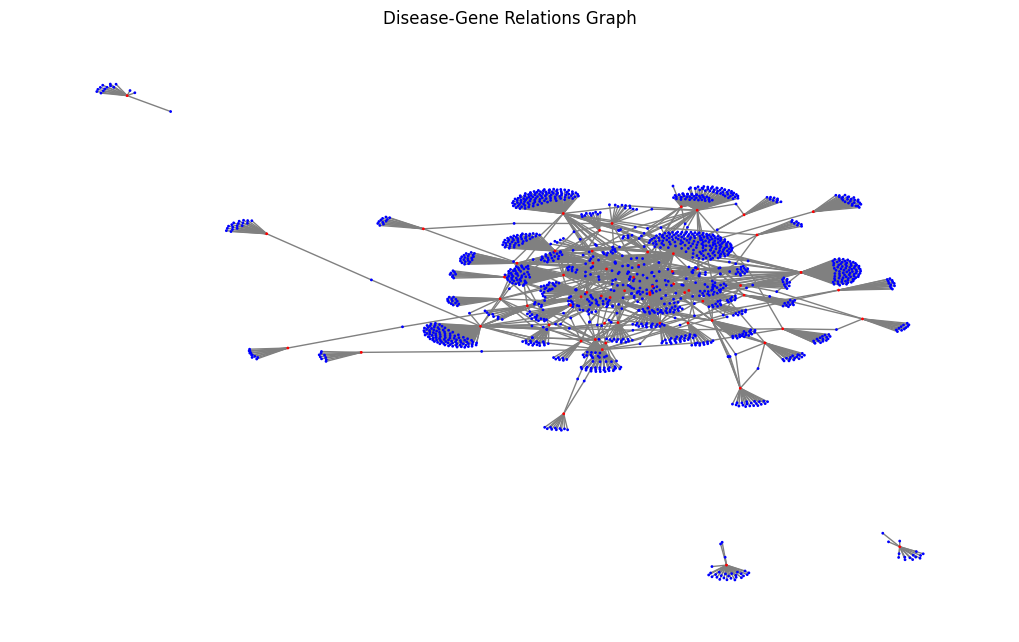

In [ ]:
# Creating a graph from the DataFrame
G = nx.from_pandas_edgelist(df_disease_gene[:2000], '# Disease ID', 'Gene ID')

node_colors = []
for node in G.nodes():
    if isinstance(node, int):  # Assuming Gene ID is an integer
        node_colors.append('blue')  # Color for Gene nodes
    else:
        node_colors.append('red')  # Color for Disease nodes

# Plotting the graph
plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=False, edge_color='gray',node_color=node_colors, node_size=1)
plt.title('Disease-Gene Relations Graph')
plt.show()